In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x = np.load('x_combined.npy')
y = np.load('y.npy')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test   = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

In [7]:
train_ds = TensorDataset(x_train_tensor, y_train_tensor)
val_ds = TensorDataset(x_val_tensor, y_val_tensor)
test_ds = TensorDataset(x_test_tensor, y_test_tensor)

In [8]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl   = DataLoader(val_ds, batch_size=32)
test_dl  = DataLoader(test_ds, batch_size=32)

In [9]:
import torch.nn as nn

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_layers=4):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]
        return self.fc(last_hidden)

In [11]:
import torch.optim as optim
from tqdm import tqdm

In [18]:
input_size = x_train.shape[2]
model = LSTM(input_size=input_size, hidden_size=128)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for xb, yb in tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        xb, yb = xb.to(device), yb.to(device).view(-1, 1)
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_dl.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            preds = model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_dl.dataset)

    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.21it/s]


Epoch 1 - Train Loss: 1.0001 | Val Loss: 1.1490


Epoch 2/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.16it/s]


Epoch 2 - Train Loss: 0.9224 | Val Loss: 1.0327


Epoch 3/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch 3 - Train Loss: 0.7638 | Val Loss: 0.8102


Epoch 4/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.32it/s]


Epoch 4 - Train Loss: 0.6100 | Val Loss: 0.6306


Epoch 5/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


Epoch 5 - Train Loss: 0.5528 | Val Loss: 0.3676


Epoch 6/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.50it/s]


Epoch 6 - Train Loss: 0.5073 | Val Loss: 0.4037


Epoch 7/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch 7 - Train Loss: 0.4130 | Val Loss: 0.5246


Epoch 8/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.52it/s]


Epoch 8 - Train Loss: 0.4987 | Val Loss: 0.9394


Epoch 9/30 - Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.43it/s]


Epoch 9 - Train Loss: 0.5658 | Val Loss: 0.6853


Epoch 10/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Epoch 10 - Train Loss: 0.4327 | Val Loss: 0.3584


Epoch 11/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.37it/s]


Epoch 11 - Train Loss: 0.3748 | Val Loss: 0.4245


Epoch 12/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Epoch 12 - Train Loss: 0.3002 | Val Loss: 0.4924


Epoch 13/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch 13 - Train Loss: 0.2672 | Val Loss: 0.4851


Epoch 14/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 14 - Train Loss: 0.2910 | Val Loss: 0.5304


Epoch 15/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 15 - Train Loss: 0.2162 | Val Loss: 0.4609


Epoch 16/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch 16 - Train Loss: 0.1910 | Val Loss: 0.4405


Epoch 17/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.23it/s]


Epoch 17 - Train Loss: 0.2398 | Val Loss: 0.8989


Epoch 18/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.23it/s]


Epoch 18 - Train Loss: 0.3251 | Val Loss: 0.2510


Epoch 19/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 19 - Train Loss: 0.3436 | Val Loss: 0.4023


Epoch 20/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Epoch 20 - Train Loss: 0.3170 | Val Loss: 0.2523


Epoch 21/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.27it/s]


Epoch 21 - Train Loss: 0.2620 | Val Loss: 0.3118


Epoch 22/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch 22 - Train Loss: 0.2930 | Val Loss: 0.2242


Epoch 23/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.29it/s]


Epoch 23 - Train Loss: 0.1745 | Val Loss: 0.1907


Epoch 24/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 24 - Train Loss: 0.2080 | Val Loss: 0.2757


Epoch 25/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Epoch 25 - Train Loss: 0.1653 | Val Loss: 0.2268


Epoch 26/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.28it/s]


Epoch 26 - Train Loss: 0.2422 | Val Loss: 0.3998


Epoch 27/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.26it/s]


Epoch 27 - Train Loss: 0.1825 | Val Loss: 0.5982


Epoch 28/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.25it/s]


Epoch 28 - Train Loss: 0.2651 | Val Loss: 0.2279


Epoch 29/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.22it/s]


Epoch 29 - Train Loss: 0.2868 | Val Loss: 0.2502


Epoch 30/30 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:05<00:00,  1.24it/s]


Epoch 30 - Train Loss: 0.2814 | Val Loss: 0.3256


Enter a lap index from test set:  10


Actual Lap Time   : 98.393 s
Predicted Lap Time: 97.394 s


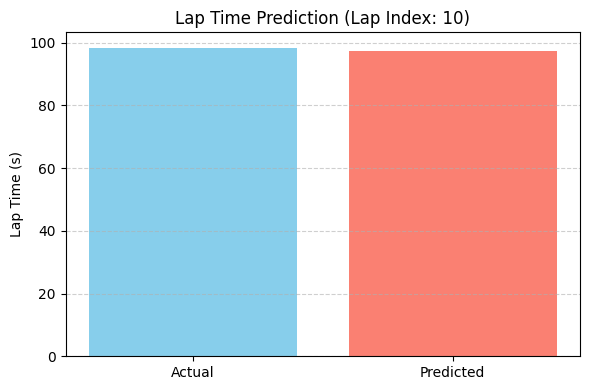

In [20]:
import matplotlib.pyplot as plt

model.eval()

idx = int(input("Enter a lap index from test set: "))

with torch.no_grad():
    inp = x_test_tensor[idx].unsqueeze(0).to(device)  # Add batch dim
    pred_scaled = model(inp).cpu().numpy()
    pred = scaler.inverse_transform(pred_scaled)[0][0]

actual = y_test[idx]

print(f"Actual Lap Time   : {actual:.3f} s")
print(f"Predicted Lap Time: {pred:.3f} s")

# Plot
plt.figure(figsize=(6, 4))
plt.bar(['Actual', 'Predicted'], [actual, pred], color=['skyblue', 'salmon'])
plt.title(f"Lap Time Prediction (Lap Index: {idx})")
plt.ylabel('Lap Time (s)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()